# Tranformers

## Imports

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

d:\GitHub Repos\VOXAID-main\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset

In [2]:
dataset = load_dataset("dair-ai/emotion")
dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## Tokenizer

In [3]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized_ds = dataset.map(tokenize, batched=True)


Map: 100%|██████████| 2000/2000 [00:00<00:00, 2388.30 examples/s]


## Data collator

In [4]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


## Model

In [5]:
num_labels = dataset["train"].features["label"].num_classes

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    num_labels=num_labels
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training Arguments

In [11]:
training_args = TrainingArguments(
    output_dir="bert-emotion",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="epoch",
    save_strategy="epoch",
    do_eval=True
)


## Evaluation Metric (Accuracy)

In [14]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)


## Trainer Setup

In [16]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


C:\Users\DELL\AppData\Local\Temp\ipykernel_2364\138472057.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Train Model

In [17]:
trainer.train()


d:\GitHub Repos\VOXAID-main\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1000,0.504500
2000,0.150200
3000,0.106400


d:\GitHub Repos\VOXAID-main\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\GitHub Repos\VOXAID-main\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=3000, training_loss=0.25370993550618487, metrics={'train_runtime': 37406.1494, 'train_samples_per_second': 1.283, 'train_steps_per_second': 0.08, 'total_flos': 584777647046016.0, 'train_loss': 0.25370993550618487, 'epoch': 3.0})

##  Evaluate

In [18]:
trainer.evaluate()


d:\GitHub Repos\VOXAID-main\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.16036461293697357,
 'eval_accuracy': 0.9355,
 'eval_runtime': 69.3682,
 'eval_samples_per_second': 28.832,
 'eval_steps_per_second': 1.802,
 'epoch': 3.0}

## Confusion Matrix

d:\GitHub Repos\VOXAID-main\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


<Figure size 800x800 with 0 Axes>

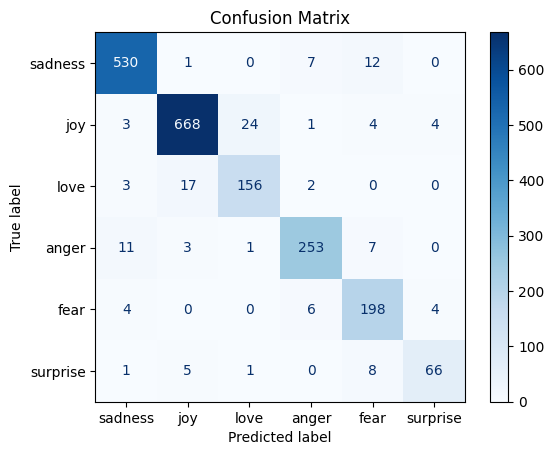

In [19]:
# Get predictions
preds = trainer.predict(tokenized_ds["validation"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=-1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=dataset["train"].features["label"].names
)
plt.figure(figsize=(8, 8))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


## Metrices


In [ ]:
import json
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# -----------------------------
# 1. Evaluate Model
# -----------------------------
eval_results = trainer.evaluate()
print("Evaluation Results:")
print(eval_results)

# -----------------------------
# 2. Save metrics to JSON file
# -----------------------------
metrics_path = "bert-emotion/bert_metrics.json"

with open(metrics_path, "w") as f:
    json.dump(eval_results, f, indent=4)

print(f"\n✅ Metrics saved to: {metrics_path}")

# -----------------------------
# 3. Confusion Matrix
# -----------------------------
preds = trainer.predict(tokenized_ds["validation"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=-1)

cm = confusion_matrix(y_true, y_pred)

# Plot & save
plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap="Blues")
plt.title("Transformer Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()

# Save confusion matrix
cm_path = "plots/Transformer_confusion_matrix.png"
plt.savefig(cm_path, dpi=300)
plt.show()

print(f"🖼️ Confusion matrix saved to: {cm_path}")
